<a href="https://colab.research.google.com/github/oshbocker/CAFA/blob/main/CAFA_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"oshbocker","key":"bb9c6a60ba5c39e689d8cf8d15cb8bca"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!pip install obonet -q
!pip install biopython -q
!pip install torchmetrics -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 56.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 36.2 MB/s eta 0:00:00


In [3]:
import os
import torch

from pathlib import Path


iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

cafa_main_path = Path("cafa-5-protein-function-prediction")
cafa_clean_fasta_path = Path("viktorfairuschin/cafa-5-fasta-files")
esm2_path = Path("viktorfairuschin/cafa-5-ems-2-embeddings-numpy")
protbert_path = Path("henriupton/protbert-embeddings-for-cafa5")
t5_path = Path("sergeifironov/t5embeds")

data_paths = [cafa_clean_fasta_path, esm2_path, protbert_path, t5_path]

if iskaggle:
  content_dir = "/kaggle/input"
else:
  content_dir = "/content"

class CFG:
    train_go_obo_path: str = f"{content_dir}/cafa-5-protein-function-prediction/Train/go-basic.obo"
    train_seq_fasta_path: str = f"{content_dir}/cafa-5-protein-function-prediction/Train/train_sequences.fasta"
    train_terms_path: str = f"{content_dir}/cafa-5-protein-function-prediction/Train/train_terms.tsv"
    train_taxonomy_path: str = f"{content_dir}/cafa-5-protein-function-prediction/Train/train_taxonomy.tsv"
    train_ia_path: str = f"{content_dir}/cafa-5-protein-function-prediction/IA.txt"
    test_sequences_path: str = f"{content_dir}/Test (Targets)/testsuperset.fasta"

    num_labels = 500
    n_epochs = 14
    batch_size = 128
    lr = 0.0005

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [4]:
if not iskaggle:
  import zipfile,kaggle
  if not cafa_main_path.exists():
    print(cafa_main_path)
    kaggle.api.competition_download_cli(str(cafa_main_path))
    zipfile.ZipFile(f'{cafa_main_path}.zip').extractall(cafa_main_path)
  for data_path in data_paths:
    if not data_path.exists():
      print(data_path)
      kaggle.api.dataset_download_files(str(data_path))
      zipfile.ZipFile(f'{data_path.name}.zip').extractall(data_path.name)

cafa-5-protein-function-prediction


100%|██████████| 115M/115M [00:07<00:00, 15.7MB/s]



viktorfairuschin/cafa-5-fasta-files
viktorfairuschin/cafa-5-ems-2-embeddings-numpy
henriupton/protbert-embeddings-for-cafa5
sergeifironov/t5embeds


In [5]:
import obonet
import time

import networkx as nx
import pandas as pd
import numpy as np
from Bio import SeqIO
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# TORCH MODULES FOR METRICS COMPUTATION :
import torch
from torch.utils.data import Dataset
from torch import nn
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics.classification import MultilabelF1Score
from torchmetrics.classification import MultilabelAccuracy

In [6]:
graph = obonet.read_obo(CFG.train_go_obo_path)

In [7]:
# Information Accretion values for terms
ia_dict = {}
with open(CFG.train_ia_path) as f:
    for line in f:
        (key, value) = line.split("\t")
        ia_dict[key] = float(value.replace("\n",""))

In [8]:
subontology_roots = {'BPO':'GO:0008150',
                     'CCO':'GO:0005575',
                     'MFO':'GO:0003674'}

BPO_len = len(nx.ancestors(graph, subontology_roots['BPO']))
CCO_len = len(nx.ancestors(graph, subontology_roots['CCO']))
MFO_len = len(nx.ancestors(graph, subontology_roots['MFO']))
print(BPO_len, CCO_len, MFO_len, BPO_len + CCO_len + MFO_len)

27941 4042 11262 43245


In [9]:
train_terms = pd.read_csv(CFG.train_terms_path, sep="\t")
train_terms['ia'] = train_terms['term'].apply(lambda x: ia_dict[x])
print(train_terms.shape)
train_terms.head(5)

(5363863, 4)


,EntryID,term,aspect,ia
0,A0A009IHW8,GO:0008152,BPO,1.598544
1,A0A009IHW8,GO:0034655,BPO,0.042274
2,A0A009IHW8,GO:0072523,BPO,0.083901
3,A0A009IHW8,GO:0044270,BPO,0.281155
4,A0A009IHW8,GO:0006753,BPO,0.013844


## Get the leaf predictions for each protein
A leaf prediction is a GO term that doesn't have any children that are also predictions for the protein.

In [10]:
def get_leaf_labels(train_terms, aspect):
    # Group by protein and get a list of all go term predictions
    protein_list_go_term = train_terms[train_terms['aspect'] == aspect].groupby('EntryID')['term'].apply(list)

    leaf_labels = {}
    for i, protein in enumerate(protein_list_go_term.index):
        test_terms = set(protein_list_go_term[protein])
        descendants = set()
        for term in test_terms:
            descendants.update(nx.descendants(graph, term))

        specific_labels = test_terms.difference(descendants)
        leaf_labels[protein] = list(specific_labels)

    return leaf_labels

from collections import deque

# Get ordered list of all ancestors
def leaf_label_ancestors(graph, leaf_labels):
    ordered_edges_dict = {}
    for label in leaf_labels:
        # Get ancestors
        ordered_edges = deque()
        node_is_root = False
        prev_node_id = label
        while node_is_root == False:
            node = graph.nodes[prev_node_id]
            node_is_root = 'is_a' not in node
            if not node_is_root:
                prev_node_id = node['is_a'][0]
                ordered_edges.appendleft(prev_node_id)
        ordered_edges_dict[label] = ordered_edges

    return ordered_edges_dict

In [11]:
def get_next_label(rw, depth=1):
    if not rw['labeled'] and len(rw['ordered_edges']) > depth:
        return rw['ordered_edges'][-depth]
    else:
        return rw['balanced_label']

def is_final_balanced_label(rw, balanced_labels, depth=1):
    if not rw['labeled']:
        return (rw['balanced_label'] in balanced_labels) or (len(rw['ordered_edges']) == depth)
    else:
        return True

def get_balanced_labels(label_df, label_count_threshold):
    df = label_df.copy()
    balanced_labels = set([label for label, count in df['label'].value_counts().items()
                           if count >= label_count_threshold])
    df['labeled'] = df['label'].apply(lambda x: x in balanced_labels)
    df['balanced_label'] = df['label'] # df.apply(lambda x: x['label'] if x['labeled'] == True else None, axis=1)
    print(sum(df['labeled'])/df.shape[0])
    print(len(balanced_labels))
    print(df['balanced_label'].value_counts())
    depth = 1
    while sum(df['labeled'])/df.shape[0] < 1:
        df['balanced_label'] = df.apply(lambda x: get_next_label(x, depth=depth), axis=1)
        balanced_labels = set([label for label, count in df['balanced_label'].value_counts().items()
                                   if count >= label_count_threshold])
        df['labeled'] = df.apply(lambda x: is_final_balanced_label(x, balanced_labels, depth=depth), axis=1)
        depth += 1
        print(sum(df['labeled'])/df.shape[0])
        print(len(balanced_labels))
        print(df['balanced_label'].value_counts())

    return df, df['balanced_label'].nunique() - 1

### Cellular Component Labels (CCO)

In [12]:
CCO_leaf_labels = get_leaf_labels(train_terms, 'CCO')
print("leaf_labels: ", len(CCO_leaf_labels.values()))
CCO_all_leaf_labels = np.unique(np.concatenate(list(CCO_leaf_labels.values())))
print("unique leaf_labels: ", len(CCO_all_leaf_labels))
CCO_nodes = [n for n,v in graph.nodes(data=True) if v['namespace'] == 'cellular_component']
CCO_ordered_edges = leaf_label_ancestors(graph, CCO_nodes)

# Get the first node label
CCO_data_with_labels = []
# Get all CCO labeled proteins with leaf labels
for protein, label_list in CCO_leaf_labels.items():
    for label in label_list:
        CCO_data_with_labels.append({'protein': protein,
                                 'label': label,
                                 'ordered_edges': CCO_ordered_edges[label]})

CCO_df = pd.DataFrame(CCO_data_with_labels)

new_CCO_df, CCO_num_labels = get_balanced_labels(CCO_df, 500)

leaf_labels:  92912
unique leaf_labels:  2763
0.612107597944911
47
GO:0005829    16981
GO:0005634    12661
GO:0005886    11509
GO:0005737     8335
GO:0005654     8160
              ...  
GO:0036026        1
GO:0036025        1
GO:0036024        1
GO:0061835        1
GO:0071202        1
Name: balanced_label, Length: 2763, dtype: int64
0.7935857682819184
65
GO:0005829    16981
GO:0005634    12725
GO:0005886    11823
GO:0110165    10149
GO:0005737     8406
              ...  
GO:0035449        1
GO:0044174        1
GO:0005879        1
GO:0044384        1
GO:0098539        1
Name: balanced_label, Length: 690, dtype: int64
0.9047031663762081
71
GO:0005829    17050
GO:0110165    14188
GO:0005634    12910
GO:0005886    11823
GO:0005737     8418
              ...  
GO:0031252        1
GO:0032994        1
GO:0035448        1
GO:0033176        1
GO:1990077        1
Name: balanced_label, Length: 294, dtype: int64
0.961806577190322
72
GO:0005829    17050
GO:0110165    16038
GO:0005634    12938
GO:

## Molecular Function Labels (MFO)

In [13]:
MFO_leaf_labels = get_leaf_labels(train_terms, 'MFO')
print("leaf labels: ", len(MFO_leaf_labels.values()))
MFO_all_leaf_labels = np.unique(np.concatenate(list(MFO_leaf_labels.values())))
print("unique leaf labels: ", len(MFO_all_leaf_labels))
MFO_nodes = [n for n,v in graph.nodes(data=True) if v['namespace'] == 'molecular_function']
MFO_ordered_edges = leaf_label_ancestors(graph, MFO_nodes)

# Get the first node label
MFO_data_with_labels = []
# Get all MFO labeled proteins with leaf labels
for protein, label_list in MFO_leaf_labels.items():
  # proteins with only protein binding GO:0005515 bias the dataset
  if label_list != ['GO:0005515']:
    for label in label_list:
        MFO_data_with_labels.append({'protein': protein,
                                 'label': label,
                                 'ordered_edges': MFO_ordered_edges[label]})

MFO_df = pd.DataFrame(MFO_data_with_labels)

new_MFO_df, MFO_num_labels = get_balanced_labels(MFO_df, 500)

leaf labels:  78637
unique leaf labels:  6866
0.30495570563985613
23
GO:0005515    11529
GO:0042802     3998
GO:0042803     1632
GO:0003729     1491
GO:0003723     1356
              ...  
GO:0016517        1
GO:0043875        1
GO:0052916        1
GO:0033094        1
GO:0102627        1
Name: balanced_label, Length: 6866, dtype: int64
0.5329707920357863
43
GO:0005515    16348
GO:0042802     3998
GO:0003723     2072
GO:0003677     1955
GO:0000976     1900
              ...  
GO:0005199        1
GO:0004376        1
GO:0001884        1
GO:0015067        1
GO:0050485        1
Name: balanced_label, Length: 1537, dtype: int64
0.715428471186738
56
GO:0005515    18352
GO:0042802     3998
GO:0003677     2622
GO:0003723     2549
GO:0005488     2172
              ...  
GO:0015278        1
GO:0001882        1
GO:0019842        1
GO:0005345        1
GO:0016409        1
Name: balanced_label, Length: 593, dtype: int64
0.8756074028593983
62
GO:0005515    18791
GO:0005488     4119
GO:0042802     3998


## Biological Process Labels (BPO)

In [14]:
BPO_leaf_labels = get_leaf_labels(train_terms, 'BPO')
print("leaf_labels: ", len(BPO_leaf_labels.values()))
BPO_all_leaf_labels = np.unique(np.concatenate(list(BPO_leaf_labels.values())))
print("unique leaf_labels: ", len(BPO_all_leaf_labels))
BPO_nodes = [n for n,v in graph.nodes(data=True) if v['namespace'] == 'biological_process']
BPO_ordered_edges = leaf_label_ancestors(graph, BPO_nodes)

# Get the first node label
BPO_data_with_labels = []
# Get all BPO labeled proteins with leaf labels
for protein, label_list in BPO_leaf_labels.items():
    for label in label_list:
        BPO_data_with_labels.append({'protein': protein,
                                 'label': label,
                                 'ordered_edges': BPO_ordered_edges[label]})

BPO_df = pd.DataFrame(BPO_data_with_labels)

new_BPO_df, BPO_num_labels = get_balanced_labels(BPO_df, 500)

leaf_labels:  92210
unique leaf_labels:  17978
0.07192198699783298
27
GO:0045944    2473
GO:0000122    1691
GO:0006355    1322
GO:0045893    1233
GO:0045892    1150
              ... 
GO:1904317       1
GO:1903235       1
GO:0098746       1
GO:0071911       1
GO:0009709       1
Name: balanced_label, Length: 17978, dtype: int64
0.28241706951158524
87
GO:0048856    3858
GO:0045944    2615
GO:0003006    2573
GO:0006950    2359
GO:0009987    2006
              ... 
GO:0045472       1
GO:0042435       1
GO:0009149       1
GO:0032534       1
GO:0046813       1
Name: balanced_label, Length: 6474, dtype: int64
0.5790698449741624
140
GO:0009987    5701
GO:0048856    5636
GO:0006950    3888
GO:0003006    3672
GO:0048513    3644
              ... 
GO:0008333       1
GO:0010520       1
GO:0090171       1
GO:0002693       1
GO:0019062       1
Name: balanced_label, Length: 2757, dtype: int64
0.7876979496582763
155
GO:0009987    8764
GO:0048856    7102
GO:0050794    4863
GO:0030154    4471
GO:0009966

## Classify selected nodes of CCO

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
def get_labels_df(balanced_label_df):
  ohe_df = pd.get_dummies(balanced_label_df, prefix=['balanced_label'], columns=['balanced_label'], drop_first=True)
  label_cols = [c for c in ohe_df.columns if 'balanced_label_' in c]
  label_df = ohe_df.groupby('protein').sum(numeric_only=True)[label_cols].clip(0,1)
  label_values = list(label_df.values)
  label_ids = list(label_df.index)
  labels_df = pd.DataFrame(data={"EntryID": label_ids, "labels_vect": label_values})
  return labels_df, label_cols

CCO_labels_df, CCO_label_cols = get_labels_df(new_CCO_df)
MFO_labels_df, MFO_label_cols = get_labels_df(new_MFO_df)
BPO_labels_df, BPO_label_cols = get_labels_df(new_BPO_df)
# Split into train, val, test
# X_train, X_test, y_train, y_test = train_test_split(label_ids,
#                                                     label_values,
#                                                     test_size = 0.2)
# print("Train label", len(y_train))
# print("Test label", len(y_test))

In [17]:
# Directories for the different embedding vectors :
embeds_map = {
    "T5" : "t5embeds",
    "ProtBERT" : "protbert-embeddings-for-cafa5",
    "ESM2" : "cafa-5-ems-2-embeddings-numpy"
}

# Length of the different embedding vectors :
embeds_dim = {
    "T5" : 1024,
    "ProtBERT" : 1024,
    "ESM2" : 1280,
    "Concat": 1280+1024,
}

In [18]:
class ProteinSequenceDataset(Dataset):

    def __init__(self, datatype, embeddings_source, subontology):
        super(ProteinSequenceDataset).__init__()
        self.datatype = datatype
        self.subontology = subontology

        if embeddings_source in ["ProtBERT", "ESM2"]:
            embeds = np.load(f"{content_dir}/"+embeds_map[embeddings_source]+"/"+datatype+"_embeddings.npy")
            ids = np.load(f"{content_dir}/"+embeds_map[embeddings_source]+"/"+datatype+"_ids.npy")

        if embeddings_source == "T5":
            embeds = np.load(f"{content_dir}/"+embeds_map[embeddings_source]+"/"+datatype+"_embeds.npy")
            ids = np.load(f"{content_dir}/"+embeds_map[embeddings_source]+"/"+datatype+"_ids.npy")

        if embeddings_source == "Concat":
            bert_embeds = np.load(f"{content_dir}/"+embeds_map["ProtBERT"]+"/"+datatype+"_embeddings.npy")
            bert_ids = np.load(f"{content_dir}/"+embeds_map["ProtBERT"]+"/"+datatype+"_ids.npy")
            esm2_embeds = np.load(f"{content_dir}/"+embeds_map["ESM2"]+"/"+datatype+"_embeddings.npy")
            esm2_ids = np.load(f"{content_dir}/"+embeds_map["ESM2"]+"/"+datatype+"_ids.npy")
            t5_embeds = np.load(f"{content_dir}/"+embeds_map["T5"]+"/"+datatype+"_embeds.npy")
            t5_ids = np.load(f"{content_dir}/"+embeds_map["T5"]+"/"+datatype+"_ids.npy")
            esm2_sorted_ids, esm2_sorted_embeds = map(list,zip(*list(sorted(zip(esm2_ids, esm2_embeds), key=lambda x: x[0]))))
            t5_sorted_ids, t5_sorted_embeds = map(list,zip(*list(sorted(zip(t5_ids, t5_embeds), key=lambda x: x[0]))))
            # t5 includes the same embedding twic
            if datatype == "test":
              del t5_sorted_ids[632]
              del t5_sorted_embeds[632]
            embeds = np.concatenate([esm2_sorted_embeds, t5_sorted_embeds], axis=1)
            embeds_list = []
            for l in range(embeds.shape[0]):
                embeds_list.append(embeds[l,:])
            self.df = pd.DataFrame(data={"EntryID": t5_sorted_ids, "embed" : embeds_list})
        else:
            embeds_list = []
            for l in range(embeds.shape[0]):
                embeds_list.append(embeds[l,:])
            self.df = pd.DataFrame(data={"EntryID": ids, "embed" : embeds_list})

        if datatype=="train":
          if subontology=="CCO":
              self.df = self.df.merge(CCO_labels_df, on="EntryID")
          if subontology=="MFO":
              self.df = self.df.merge(MFO_labels_df, on="EntryID")
          if subontology=="BPO":
              self.df = self.df.merge(BPO_labels_df, on="EntryID")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        embed = torch.tensor(self.df.iloc[index]["embed"] , dtype = torch.float32)
        if self.datatype=="train":
            targets = torch.tensor(self.df.iloc[index]["labels_vect"], dtype = torch.float32)
            return embed, targets
        if self.datatype=="test":
            id = self.df.iloc[index]["EntryID"]
            return embed, id

In [19]:
datatype = "test"
bert_embeds = np.load(f"{content_dir}/"+embeds_map["ProtBERT"]+"/"+datatype+"_embeddings.npy")
bert_ids = np.load(f"{content_dir}/"+embeds_map["ProtBERT"]+"/"+datatype+"_ids.npy")
esm2_embeds = np.load(f"{content_dir}/"+embeds_map["ESM2"]+"/"+datatype+"_embeddings.npy")
esm2_ids = np.load(f"{content_dir}/"+embeds_map["ESM2"]+"/"+datatype+"_ids.npy")
t5_embeds = np.load(f"{content_dir}/"+embeds_map["T5"]+"/"+datatype+"_embeds.npy")
t5_ids = np.load(f"{content_dir}/"+embeds_map["T5"]+"/"+datatype+"_ids.npy")

In [20]:
esm2_sorted_ids, esm2_sorted_embeds = map(list,zip(*list(sorted(zip(esm2_ids, esm2_embeds), key=lambda x: x[0]))))
t5_sorted_ids, t5_sorted_embeds = map(list,zip(*list(sorted(zip(t5_ids, t5_embeds), key=lambda x: x[0]))))

In [21]:
print(len(esm2_sorted_ids))
print(len(t5_sorted_ids))

141864
141865


In [22]:
class MultiLayerPerceptron(torch.nn.Module):

    def __init__(self, input_dim, num_classes, p):
        super(MultiLayerPerceptron, self).__init__()

        self.linear1 = torch.nn.Linear(input_dim, 4*1012)
        self.activation1 = torch.nn.ReLU()
        self.dropout1 = torch.nn.Dropout(p)
        self.linear2 = torch.nn.Linear(4*1012, 4*712)
        self.activation2 = torch.nn.ReLU()
        self.dropout2 = torch.nn.Dropout(p)
        self.linear3 = torch.nn.Linear(4*712, num_classes)

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation1(x)
        x = self.dropout1(x)
        x = self.linear2(x)
        x = self.activation2(x)
        x = self.dropout2(x)
        x = self.linear3(x)
        return x


class CNN1D(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(CNN1D, self).__init__()
        # (batch_size, channels, embed_size)
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=3, kernel_size=3, dilation=1, padding=1, stride=1)
        # (batch_size, 3, embed_size)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        # (batch_size, 3, embed_size/2 = 512)
        self.conv2 = nn.Conv1d(in_channels=3, out_channels=8, kernel_size=3, dilation=1, padding=1, stride=1)
        # (batch_size, 8, embed_size/2 = 512)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        # (batch_size, 8, embed_size/4 = 256)
        self.fc1 = nn.Linear(in_features=int(8 * input_dim/4), out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=num_classes)

    def forward(self, x):
        x = x.reshape(x.shape[0], 1, x.shape[1])
        x = self.pool1(nn.functional.relu(self.conv1(x)))
        x = self.pool2(nn.functional.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [23]:
def train_model(embeddings_source, subontology, num_labels, model_type="linear", train_size=0.9):

    train_dataset = ProteinSequenceDataset(datatype="train", embeddings_source = embeddings_source, subontology=subontology)

    train_set, val_set = random_split(train_dataset, lengths = [int(len(train_dataset)*train_size), len(train_dataset)-int(len(train_dataset)*train_size)])
    train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=CFG.batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=CFG.batch_size, shuffle=True)

    if model_type == "linear":
        model = MultiLayerPerceptron(input_dim=embeds_dim[embeddings_source], num_classes=num_labels, p=0.2).to(CFG.device)
    if model_type == "convolutional":
        model = CNN1D(input_dim=embeds_dim[embeddings_source], num_classes=num_labels).to(CFG.device)

    optimizer = torch.optim.Adam(model.parameters(), lr = CFG.lr)
    scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=1)
    CrossEntropy = torch.nn.CrossEntropyLoss()
    f1_score = MultilabelF1Score(num_labels=num_labels).to(CFG.device)
    n_epochs = CFG.n_epochs

    print("BEGIN TRAINING...")
    train_loss_history=[]
    val_loss_history=[]

    train_f1score_history=[]
    val_f1score_history=[]
    for epoch in range(n_epochs):
        print("EPOCH ", epoch+1)
        ## TRAIN PHASE :
        losses = []
        scores = []
        for embed, targets in tqdm(train_dataloader):
            embed, targets = embed.to(CFG.device), targets.to(CFG.device)
            optimizer.zero_grad()
            preds = model(embed)
            loss= CrossEntropy(preds, targets)
            score=f1_score(preds, targets)
            losses.append(loss.item())
            scores.append(score.item())
            loss.backward()
            optimizer.step()
        avg_loss = np.mean(losses)
        avg_score = np.mean(scores)
        print("Running Average TRAIN Loss : ", avg_loss)
        print("Running Average TRAIN F1-Score : ", avg_score)
        train_loss_history.append(avg_loss)
        train_f1score_history.append(avg_score)

        ## VALIDATION PHASE :
        losses = []
        scores = []
        for embed, targets in val_dataloader:
            embed, targets = embed.to(CFG.device), targets.to(CFG.device)
            preds = model(embed)
            loss= CrossEntropy(preds, targets)
            score=f1_score(preds, targets)
            losses.append(loss.item())
            scores.append(score.item())
        avg_loss = np.mean(losses)
        avg_score = np.mean(scores)
        print("Running Average VAL Loss : ", avg_loss)
        print("Running Average VAL F1-Score : ", avg_score)
        val_loss_history.append(avg_loss)
        val_f1score_history.append(avg_score)

        scheduler.step(avg_loss)
        print("\n")

    print("TRAINING FINISHED")
    print("FINAL TRAINING SCORE : ", train_f1score_history[-1])
    print("FINAL VALIDATION SCORE : ", val_f1score_history[-1])

    losses_history = {"train" : train_loss_history, "val" : val_loss_history}
    scores_history = {"train" : train_f1score_history, "val" : val_f1score_history}

    return model, losses_history, scores_history

In [24]:
# cat_CCO_model, cat_CCO_losses, cat_CCO_scores = train_model(embeddings_source="Concat", subontology="CCO", num_labels=CCO_num_labels, model_type="linear")

In [25]:
# esm2_model, esm2_losses, esm2_scores = train_model(embeddings_source="ESM2",model_type="linear")

In [26]:
# Weighted F1 Score?

In [27]:
t5_CCO_model, t5_CCO_losses, t5_CCO_scores = train_model(embeddings_source="T5", subontology="CCO", num_labels=CCO_num_labels, model_type="linear")

BEGIN TRAINING...
EPOCH  1


100%|██████████| 654/654 [00:16<00:00, 39.04it/s]


Running Average TRAIN Loss :  5.421647026633633
Running Average TRAIN F1-Score :  0.11127855327401869
Running Average VAL Loss :  5.151562560094546
Running Average VAL F1-Score :  0.12984558317351014


EPOCH  2


100%|██████████| 654/654 [00:14<00:00, 44.88it/s]


Running Average TRAIN Loss :  4.9711259585272645
Running Average TRAIN F1-Score :  0.14141249262502797
Running Average VAL Loss :  5.016960019934667
Running Average VAL F1-Score :  0.1437857453137228


EPOCH  3


100%|██████████| 654/654 [00:14<00:00, 44.97it/s]


Running Average TRAIN Loss :  4.780713874994797
Running Average TRAIN F1-Score :  0.15679978590675087
Running Average VAL Loss :  4.877194985951463
Running Average VAL F1-Score :  0.1547795875023489


EPOCH  4


100%|██████████| 654/654 [00:14<00:00, 45.57it/s]


Running Average TRAIN Loss :  4.612421071857487
Running Average TRAIN F1-Score :  0.17048754969138982
Running Average VAL Loss :  4.812421903218309
Running Average VAL F1-Score :  0.1639905514782422


EPOCH  5


100%|██████████| 654/654 [00:14<00:00, 44.74it/s]


Running Average TRAIN Loss :  4.449606974555083
Running Average TRAIN F1-Score :  0.1827694949343664
Running Average VAL Loss :  4.765577538372719
Running Average VAL F1-Score :  0.172270268201828


EPOCH  6


100%|██████████| 654/654 [00:14<00:00, 44.89it/s]


Running Average TRAIN Loss :  4.2941442585866385
Running Average TRAIN F1-Score :  0.1974150923732953
Running Average VAL Loss :  4.738558635319749
Running Average VAL F1-Score :  0.17958758220280688


EPOCH  7


100%|██████████| 654/654 [00:14<00:00, 45.17it/s]


Running Average TRAIN Loss :  4.136081424328165
Running Average TRAIN F1-Score :  0.21103670492494872
Running Average VAL Loss :  4.697711490604975
Running Average VAL F1-Score :  0.19281210597247295


EPOCH  8


100%|██████████| 654/654 [00:14<00:00, 45.97it/s]


Running Average TRAIN Loss :  3.9918842483368855
Running Average TRAIN F1-Score :  0.22501130618542342
Running Average VAL Loss :  4.705125952420169
Running Average VAL F1-Score :  0.20248554381605696


EPOCH  9


100%|██████████| 654/654 [00:14<00:00, 45.85it/s]


Running Average TRAIN Loss :  3.8491812503301404
Running Average TRAIN F1-Score :  0.2386671453486524
Running Average VAL Loss :  4.713494255118174
Running Average VAL F1-Score :  0.20395901186825477


EPOCH  10


100%|██████████| 654/654 [00:14<00:00, 45.80it/s]


Running Average TRAIN Loss :  3.518606481566706
Running Average TRAIN F1-Score :  0.2567187799909793
Running Average VAL Loss :  4.698014474894903
Running Average VAL F1-Score :  0.21283306773394756


EPOCH  11


100%|██████████| 654/654 [00:14<00:00, 45.93it/s]


Running Average TRAIN Loss :  3.4418405341810407
Running Average TRAIN F1-Score :  0.2655883141841728
Running Average VAL Loss :  4.7057746207877384
Running Average VAL F1-Score :  0.21637855858018953


EPOCH  12


100%|██████████| 654/654 [00:14<00:00, 45.89it/s]


Running Average TRAIN Loss :  3.385873413231759
Running Average TRAIN F1-Score :  0.2693659574340243
Running Average VAL Loss :  4.721752160216031
Running Average VAL F1-Score :  0.21677856698428113


EPOCH  13


100%|██████████| 654/654 [00:14<00:00, 46.04it/s]


Running Average TRAIN Loss :  3.3785911437568314
Running Average TRAIN F1-Score :  0.26922603582661453
Running Average VAL Loss :  4.716557910997573
Running Average VAL F1-Score :  0.21553278112248198


EPOCH  14


100%|██████████| 654/654 [00:14<00:00, 45.69it/s]


Running Average TRAIN Loss :  3.3739768499992673
Running Average TRAIN F1-Score :  0.2713187280643606
Running Average VAL Loss :  4.722561656612239
Running Average VAL F1-Score :  0.21908662539638885


TRAINING FINISHED
FINAL TRAINING SCORE :  0.2713187280643606
FINAL VALIDATION SCORE :  0.21908662539638885


In [28]:
# protbert_model, protbert_losses, protbert_scores = train_model(embeddings_source="T5",model_type="linear")

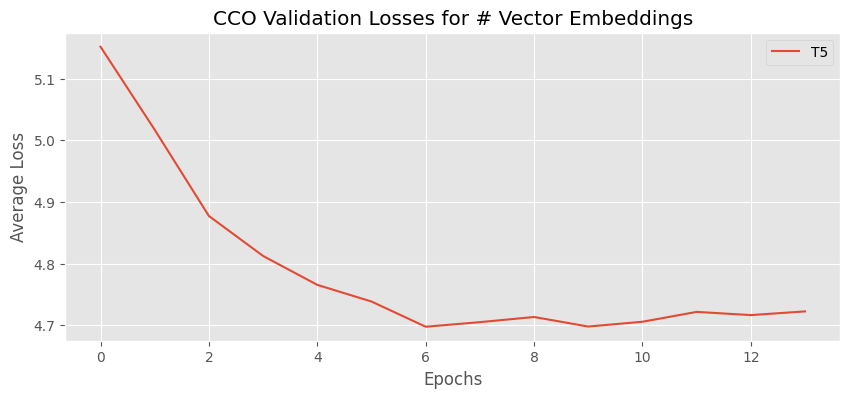

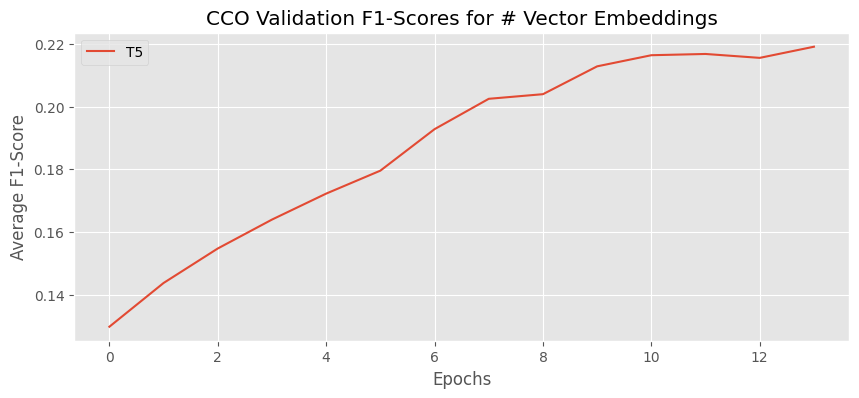

In [29]:
plt.figure(figsize = (10, 4))
# plt.plot(esm2_losses["val"], label = "ESM2")
plt.plot(t5_CCO_losses["val"], label = "T5")
# plt.plot(protbert_losses["val"], label = "ProtBERT")
# plt.plot(cat_CCO_losses["val"], label = "Concat")
plt.title("CCO Validation Losses for # Vector Embeddings")
plt.xlabel("Epochs")
plt.ylabel("Average Loss")
plt.legend()
plt.show()

plt.figure(figsize = (10, 4))
# plt.plot(esm2_scores["val"], label = "ESM2")
plt.plot(t5_CCO_scores["val"], label = "T5")
# plt.plot(protbert_scores["val"], label = "ProtBERT")
# plt.plot(cat_CCO_scores["val"], label = "Concat")
plt.title("CCO Validation F1-Scores for # Vector Embeddings")
plt.xlabel("Epochs")
plt.ylabel("Average F1-Score")
plt.legend()
plt.show()

In [30]:
# cat_MFO_model, cat_MFO_losses, cat_MFO_scores = train_model(embeddings_source="Concat", subontology="MFO", num_labels=MFO_num_labels, model_type="linear")

In [31]:
t5_MFO_model, t5_MFO_losses, t5_MFO_scores = train_model(embeddings_source="T5", subontology="MFO", num_labels=MFO_num_labels, model_type="linear")

BEGIN TRAINING...
EPOCH  1


100%|██████████| 422/422 [00:09<00:00, 45.41it/s]


Running Average TRAIN Loss :  4.8402909808814245
Running Average TRAIN F1-Score :  0.0891817084235532
Running Average VAL Loss :  4.29831555041861
Running Average VAL F1-Score :  0.11448723458229228


EPOCH  2


100%|██████████| 422/422 [00:09<00:00, 44.51it/s]


Running Average TRAIN Loss :  4.136548680716781
Running Average TRAIN F1-Score :  0.12589439959817023
Running Average VAL Loss :  4.086529914368975
Running Average VAL F1-Score :  0.13361529641328973


EPOCH  3


100%|██████████| 422/422 [00:09<00:00, 44.26it/s]


Running Average TRAIN Loss :  3.8976710498050493
Running Average TRAIN F1-Score :  0.1462836929760273
Running Average VAL Loss :  3.961406038162556
Running Average VAL F1-Score :  0.155886746467428


EPOCH  4


100%|██████████| 422/422 [00:09<00:00, 44.52it/s]


Running Average TRAIN Loss :  3.7155968380200353
Running Average TRAIN F1-Score :  0.16335931060155987
Running Average VAL Loss :  3.86118413539643
Running Average VAL F1-Score :  0.16899826520300926


EPOCH  5


100%|██████████| 422/422 [00:09<00:00, 44.34it/s]


Running Average TRAIN Loss :  3.5676458989274447
Running Average TRAIN F1-Score :  0.17875512029039917
Running Average VAL Loss :  3.825617582240003
Running Average VAL F1-Score :  0.18336774852681667


EPOCH  6


100%|██████████| 422/422 [00:09<00:00, 44.48it/s]


Running Average TRAIN Loss :  3.4215066464026394
Running Average TRAIN F1-Score :  0.1929338172219376
Running Average VAL Loss :  3.7690596631232727
Running Average VAL F1-Score :  0.19079494983591933


EPOCH  7


100%|██████████| 422/422 [00:09<00:00, 45.13it/s]


Running Average TRAIN Loss :  3.292066537373439
Running Average TRAIN F1-Score :  0.20772262168297836
Running Average VAL Loss :  3.7617513626179795
Running Average VAL F1-Score :  0.2064760961431138


EPOCH  8


100%|██████████| 422/422 [00:09<00:00, 44.62it/s]


Running Average TRAIN Loss :  3.1693548709860346
Running Average TRAIN F1-Score :  0.21989185626119798
Running Average VAL Loss :  3.756294859216568
Running Average VAL F1-Score :  0.21239556974553048


EPOCH  9


100%|██████████| 422/422 [00:09<00:00, 44.81it/s]


Running Average TRAIN Loss :  3.055309019382531
Running Average TRAIN F1-Score :  0.231682884573089
Running Average VAL Loss :  3.7862601026575615
Running Average VAL F1-Score :  0.2185193366826849


EPOCH  10


100%|██████████| 422/422 [00:09<00:00, 44.78it/s]


Running Average TRAIN Loss :  2.949815559726191
Running Average TRAIN F1-Score :  0.243143596355384
Running Average VAL Loss :  3.8018847272751177
Running Average VAL F1-Score :  0.2296858880114048


EPOCH  11


100%|██████████| 422/422 [00:09<00:00, 44.62it/s]


Running Average TRAIN Loss :  2.6848891860500896
Running Average TRAIN F1-Score :  0.2575700730968143
Running Average VAL Loss :  3.745883738740962
Running Average VAL F1-Score :  0.2382034402578435


EPOCH  12


100%|██████████| 422/422 [00:09<00:00, 44.92it/s]


Running Average TRAIN Loss :  2.615366174428949
Running Average TRAIN F1-Score :  0.263400774122485
Running Average VAL Loss :  3.7444635959381753
Running Average VAL F1-Score :  0.23903716308005313


EPOCH  13


100%|██████████| 422/422 [00:09<00:00, 45.69it/s]


Running Average TRAIN Loss :  2.5834462718941023
Running Average TRAIN F1-Score :  0.26733334071192694
Running Average VAL Loss :  3.773316210888802
Running Average VAL F1-Score :  0.24002160480681886


EPOCH  14


100%|██████████| 422/422 [00:09<00:00, 44.55it/s]


Running Average TRAIN Loss :  2.5726098892813045
Running Average TRAIN F1-Score :  0.27116865961331327
Running Average VAL Loss :  3.7781328140421118
Running Average VAL F1-Score :  0.24322945038054852


TRAINING FINISHED
FINAL TRAINING SCORE :  0.27116865961331327
FINAL VALIDATION SCORE :  0.24322945038054852


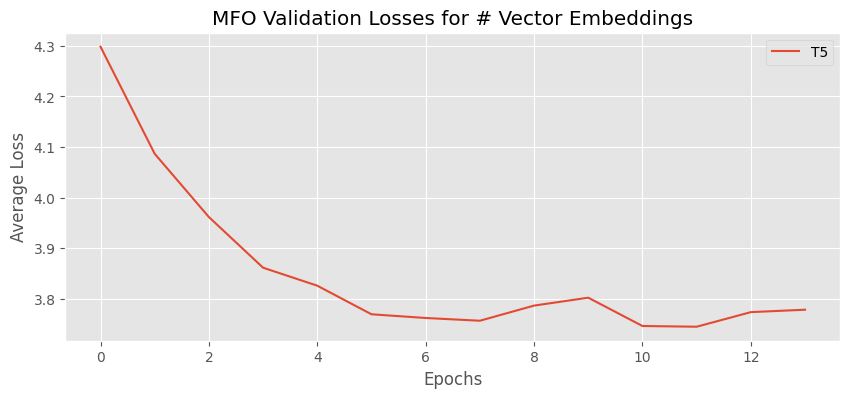

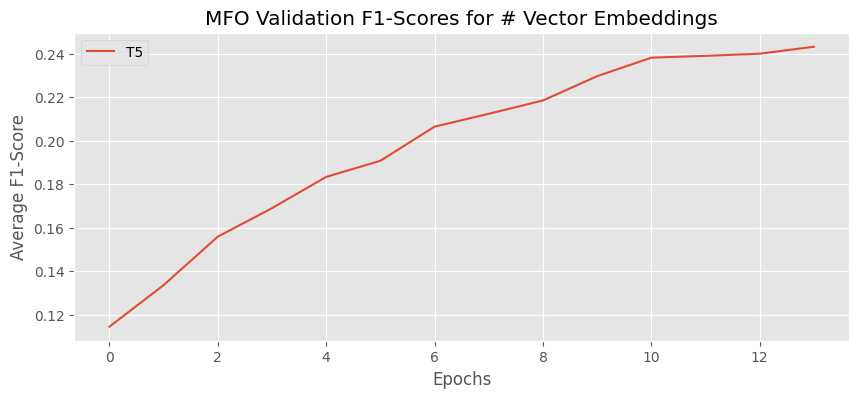

In [32]:
plt.figure(figsize = (10, 4))
# plt.plot(esm2_losses["val"], label = "ESM2")
plt.plot(t5_MFO_losses["val"], label = "T5")
# plt.plot(protbert_losses["val"], label = "ProtBERT")
# plt.plot(cat_MFO_losses["val"], label = "Concat")
plt.title("MFO Validation Losses for # Vector Embeddings")
plt.xlabel("Epochs")
plt.ylabel("Average Loss")
plt.legend()
plt.show()

plt.figure(figsize = (10, 4))
# plt.plot(esm2_scores["val"], label = "ESM2")
plt.plot(t5_MFO_scores["val"], label = "T5")
# plt.plot(protbert_scores["val"], label = "ProtBERT")
# plt.plot(cat_MFO_scores["val"], label = "Concat")
plt.title("MFO Validation F1-Scores for # Vector Embeddings")
plt.xlabel("Epochs")
plt.ylabel("Average F1-Score")
plt.legend()
plt.show()

In [33]:
# cat_BPO_model, cat_BPO_losses, cat_BPO_scores = train_model(embeddings_source="Concat", subontology="BPO", num_labels=BPO_num_labels, model_type="linear")

In [34]:
t5_BPO_model, t5_BPO_losses, t5_BPO_scores = train_model(embeddings_source="T5", subontology="BPO", num_labels=BPO_num_labels, model_type="linear")

BEGIN TRAINING...
EPOCH  1


100%|██████████| 649/649 [00:14<00:00, 44.51it/s]


Running Average TRAIN Loss :  12.26914678406091
Running Average TRAIN F1-Score :  0.07144741015724022
Running Average VAL Loss :  12.408852093840299
Running Average VAL F1-Score :  0.08828130231736457


EPOCH  2


100%|██████████| 649/649 [00:14<00:00, 44.80it/s]


Running Average TRAIN Loss :  11.590016056466359
Running Average TRAIN F1-Score :  0.09255263515861449
Running Average VAL Loss :  11.8894722690321
Running Average VAL F1-Score :  0.0974844998284562


EPOCH  3


100%|██████████| 649/649 [00:14<00:00, 45.23it/s]


Running Average TRAIN Loss :  11.259997744773312
Running Average TRAIN F1-Score :  0.10381740360350014
Running Average VAL Loss :  11.605700512454934
Running Average VAL F1-Score :  0.10785282918647544


EPOCH  4


100%|██████████| 649/649 [00:14<00:00, 44.94it/s]


Running Average TRAIN Loss :  10.959786436407152
Running Average TRAIN F1-Score :  0.11454495504062238
Running Average VAL Loss :  11.583373553132358
Running Average VAL F1-Score :  0.11501637075657714


EPOCH  5


100%|██████████| 649/649 [00:14<00:00, 44.93it/s]


Running Average TRAIN Loss :  10.665978451539262
Running Average TRAIN F1-Score :  0.12570533053074118
Running Average VAL Loss :  11.35817576761115
Running Average VAL F1-Score :  0.12242584124411622


EPOCH  6


100%|██████████| 649/649 [00:14<00:00, 44.78it/s]


Running Average TRAIN Loss :  10.37807342341207
Running Average TRAIN F1-Score :  0.13744763716573158
Running Average VAL Loss :  11.344181988337269
Running Average VAL F1-Score :  0.13213920889243688


EPOCH  7


100%|██████████| 649/649 [00:14<00:00, 44.74it/s]


Running Average TRAIN Loss :  10.098057907792196
Running Average TRAIN F1-Score :  0.1497728003099997
Running Average VAL Loss :  11.231655179637752
Running Average VAL F1-Score :  0.13695608615262866


EPOCH  8


100%|██████████| 649/649 [00:14<00:00, 44.84it/s]


Running Average TRAIN Loss :  9.824011973864492
Running Average TRAIN F1-Score :  0.1624273993935901
Running Average VAL Loss :  11.10553970728835
Running Average VAL F1-Score :  0.14693638100607753


EPOCH  9


100%|██████████| 649/649 [00:14<00:00, 44.79it/s]


Running Average TRAIN Loss :  9.559561924133536
Running Average TRAIN F1-Score :  0.17471610413769545
Running Average VAL Loss :  11.156066933723345
Running Average VAL F1-Score :  0.15308220327308733


EPOCH  10


100%|██████████| 649/649 [00:14<00:00, 45.11it/s]


Running Average TRAIN Loss :  9.307927463014247
Running Average TRAIN F1-Score :  0.18552221004235542
Running Average VAL Loss :  11.073168741513605
Running Average VAL F1-Score :  0.15900805641016733


EPOCH  11


100%|██████████| 649/649 [00:14<00:00, 44.89it/s]


Running Average TRAIN Loss :  9.075026920653638
Running Average TRAIN F1-Score :  0.19715701888540677
Running Average VAL Loss :  11.099657346124518
Running Average VAL F1-Score :  0.16301030675842337


EPOCH  12


100%|██████████| 649/649 [00:14<00:00, 45.06it/s]


Running Average TRAIN Loss :  8.856237742860438
Running Average TRAIN F1-Score :  0.20770049510733188
Running Average VAL Loss :  11.15722294376321
Running Average VAL F1-Score :  0.16861246516035028


EPOCH  13


100%|██████████| 649/649 [00:14<00:00, 44.53it/s]


Running Average TRAIN Loss :  8.346487239255744
Running Average TRAIN F1-Score :  0.22516334033894062
Running Average VAL Loss :  11.270444007769022
Running Average VAL F1-Score :  0.17762258332477857


EPOCH  14


100%|██████████| 649/649 [00:14<00:00, 44.55it/s]


Running Average TRAIN Loss :  8.228762067521481
Running Average TRAIN F1-Score :  0.23265213444714186
Running Average VAL Loss :  11.22472503087292
Running Average VAL F1-Score :  0.1772472494064945


TRAINING FINISHED
FINAL TRAINING SCORE :  0.23265213444714186
FINAL VALIDATION SCORE :  0.1772472494064945


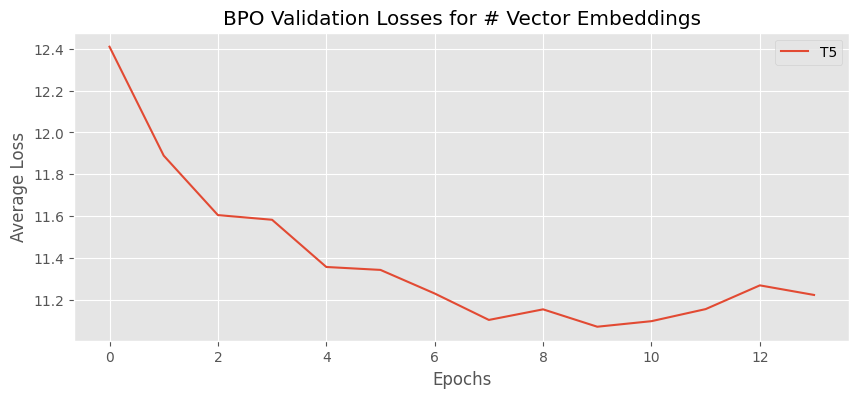

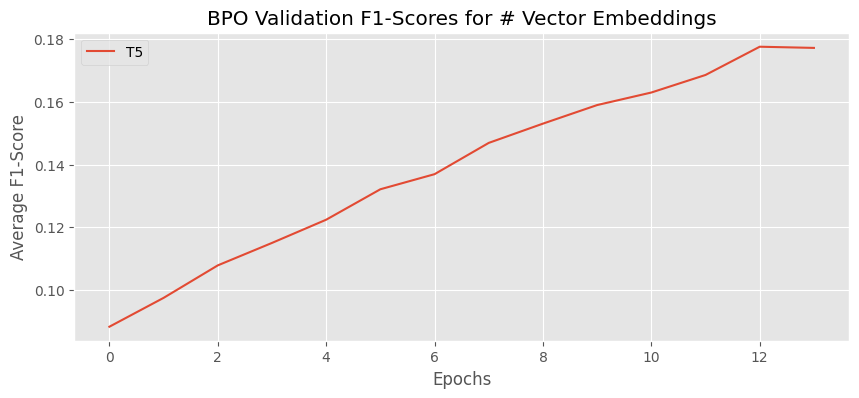

In [35]:
plt.figure(figsize = (10, 4))
# plt.plot(esm2_losses["val"], label = "ESM2")
plt.plot(t5_BPO_losses["val"], label = "T5")
# plt.plot(protbert_losses["val"], label = "ProtBERT")
# plt.plot(cat_BPO_losses["val"], label = "Concat")
plt.title("BPO Validation Losses for # Vector Embeddings")
plt.xlabel("Epochs")
plt.ylabel("Average Loss")
plt.legend()
plt.show()

plt.figure(figsize = (10, 4))
# plt.plot(esm2_scores["val"], label = "ESM2")
plt.plot(t5_BPO_scores["val"], label = "T5")
# plt.plot(protbert_scores["val"], label = "ProtBERT")
# plt.plot(cat_BPO_scores["val"], label = "Concat")
plt.title("BPO Validation F1-Scores for # Vector Embeddings")
plt.xlabel("Epochs")
plt.ylabel("Average F1-Score")
plt.legend()
plt.show()

## Make Predictions

In [36]:
model_map = {
    "CCO": {
        "T5": t5_CCO_model,
        # "ProtBERT": protbert_CCO_model,
        # "ESM2": esm2_CCO_model,
        # "Concat": cat_CCO_model,
        "labels": CCO_label_cols,
        "num_labels": CCO_num_labels,
    },
    "MFO": {
        "T5": t5_MFO_model,
        # "ProtBERT": protbert_MFO_model,
        # "ESM2": esm2_MFO_model,
        # "Concat": cat_MFO_model,
        "labels": MFO_label_cols,
        "num_labels": MFO_num_labels,
    },
    "BPO": {
        "T5": t5_BPO_model,
        # "ProtBERT": protbert_MFO_model,
        # "ESM2": esm2_MFO_model,
        # "Concat": cat_BPO_model,
        "labels": BPO_label_cols,
        "num_labels": BPO_num_labels,
    }
}

In [37]:
def predict(embeddings_source, subontology):

    test_dataset = ProteinSequenceDataset(datatype="test", embeddings_source = embeddings_source, subontology=subontology)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

    model = model_map[subontology][embeddings_source]
    label_cols = model_map[subontology]["labels"]
    num_labels = model_map[subontology]["num_labels"]

    model.eval()

    labels = pd.read_csv(CFG.train_terms_path, sep = "\t")
    top_terms = labels.groupby("term")["EntryID"].count().sort_values(ascending=False)
    labels_names = [label.split('_')[-1] for label in label_cols]
    print("GENERATE PREDICTION FOR TEST SET...")

    ids_ = np.empty(shape=(len(test_dataloader)*num_labels,), dtype=object)
    go_terms_ = np.empty(shape=(len(test_dataloader)*num_labels,), dtype=object)
    confs_ = np.empty(shape=(len(test_dataloader)*num_labels,), dtype=np.float32)

    for i, (embed, id) in tqdm(enumerate(test_dataloader)):
        embed = embed.to(CFG.device)
        confs_[i*num_labels:(i+1)*num_labels] = torch.nn.functional.sigmoid(model(embed)).squeeze().detach().cpu().numpy()
        ids_[i*num_labels:(i+1)*num_labels] = id[0]
        go_terms_[i*num_labels:(i+1)*num_labels] = labels_names

    submission_df = pd.DataFrame(data={"Id" : ids_, "GO term" : go_terms_, "Confidence" : confs_})
    print("PREDICTIONS DONE")
    return submission_df

In [38]:
CCO_submission_df = predict("T5", "CCO")
print(len(CCO_submission_df))
print(len(CCO_submission_df["GO term"].unique()))
CCO_submission_df.head()

GENERATE PREDICTION FOR TEST SET...


141865it [01:45, 1342.73it/s]


PREDICTIONS DONE
10356145
73


,Id,GO term,Confidence
0,Q9CQV8,GO:0000325,0.021925
1,Q9CQV8,GO:0000785,0.030021
2,Q9CQV8,GO:0005576,0.074709
3,Q9CQV8,GO:0005615,0.322998
4,Q9CQV8,GO:0005618,0.032581


In [39]:
MFO_submission_df = predict("T5", "MFO")
print(len(MFO_submission_df))
print(len(MFO_submission_df["GO term"].unique()))
MFO_submission_df.head()

GENERATE PREDICTION FOR TEST SET...


141865it [01:45, 1343.04it/s]


PREDICTIONS DONE
12058525
85


,Id,GO term,Confidence
0,Q9CQV8,GO:0000976,0.155730
1,Q9CQV8,GO:0000978,0.168526
2,Q9CQV8,GO:0000981,0.011124
3,Q9CQV8,GO:0001228,0.021938
4,Q9CQV8,GO:0003677,0.669455


In [40]:
BPO_submission_df = predict("T5", "BPO")
print(len(BPO_submission_df))
print(len(BPO_submission_df["GO term"].unique()))
BPO_submission_df.head()

GENERATE PREDICTION FOR TEST SET...


141865it [01:46, 1330.22it/s]


PREDICTIONS DONE
24117050
170


,Id,GO term,Confidence
0,Q9CQV8,GO:0000122,0.271336
1,Q9CQV8,GO:0000904,0.542746
2,Q9CQV8,GO:0001666,0.035028
3,Q9CQV8,GO:0001817,0.017263
4,Q9CQV8,GO:0001819,0.076005


In [41]:
id_list = []
go_term_list = []
confidence_list = []
for rw in CCO_submission_df.values:
  edges = CCO_ordered_edges[rw[1]]
  for edge in edges:
    id_list.append(rw[0])
    go_term_list.append(edge)
    confidence_list.append(rw[2])
additional_labels = pd.DataFrame({'Id': id_list, 'GO term': go_term_list, 'Confidence': confidence_list})

In [42]:
submission_df = pd.concat([CCO_submission_df, MFO_submission_df, BPO_submission_df,]).drop_duplicates(['Id', 'GO term']).reset_index(drop=True)

In [43]:
print(len(submission_df))  # 16546208
print(len(submission_df["GO term"].unique())) # 328
submission_df.head()

46531392
328


,Id,GO term,Confidence
0,Q9CQV8,GO:0000325,0.021925
1,Q9CQV8,GO:0000785,0.030021
2,Q9CQV8,GO:0005576,0.074709
3,Q9CQV8,GO:0005615,0.322998
4,Q9CQV8,GO:0005618,0.032581


In [44]:
submission_df['Id'].unique()[:5]

array(['Q9CQV8', 'P62259', 'P68510', 'P61982', 'O70456'], dtype=object)

In [45]:
protein_id = 'P68510'
subset_df = submission_df[submission_df['Id'] == protein_id].reset_index(drop=True)

In [46]:
subset_df.loc[subset_df['Confidence'].argmax()]

Id                P68510
GO term       GO:0005515
Confidence      0.937458
Name: 95, dtype: object

In [47]:
subset_df.sort_values(['Confidence'], ascending=False).head(7)

,Id,GO term,Confidence
95,P68510,GO:0005515,0.937458
122,P68510,GO:0019904,0.914894
120,P68510,GO:0019899,0.905109
22,P68510,GO:0005829,0.891607
140,P68510,GO:0046982,0.854988
68,P68510,GO:0110165,0.848707
5,P68510,GO:0005634,0.808764


In [48]:
train_terms[(train_terms['EntryID'] == protein_id) & (train_terms['aspect'] == 'CCO')]

,EntryID,term,aspect,ia
4032360,P68510,GO:0005622,CCO,0.366945
4032361,P68510,GO:0060076,CCO,4.520144
4032362,P68510,GO:0014704,CCO,0.525320
4032363,P68510,GO:0044291,CCO,3.752804
4032364,P68510,GO:0005575,CCO,0.000000
4032365,P68510,GO:0098984,CCO,2.297752
4032366,P68510,GO:0098978,CCO,1.802445
4032367,P68510,GO:0032279,CCO,0.102393
4032368,P68510,GO:0005829,CCO,1.545978
4032369,P68510,GO:0150048,CCO,1.415037


In [49]:
submission_df.to_csv('submission.tsv', sep='\t', index=False)